# Importations

In [1]:
import pandas as pd
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.linear_model import LinearRegression
from itertools import permutations, combinations
from math import inf, isfinite
from copy import deepcopy
from POLIST_03_fonctions import *
import random
import seaborn as sns
sns.set()
profile_customers = pd.read_csv('profile_customers.csv')
profile_customers = profile_customers.dropna(subset=['review_score']).reset_index(drop=True)

Pour rappel, voici les variables disponibles:

In [2]:
# columns_quali: Colonnes des données qualitatives
columns_quali = ['state_name', 'product_category_name', 'nb_purchase', 'seller_id', 'seller_state_name']
# columns_quanti: Colonnes des données quantitatives
columns_quanti = profile_customers.columns.difference(columns_quali).tolist()
print("Variables qualitatives:", columns_quali)
print("Variables quantitatives:", columns_quanti)

Variables qualitatives: ['state_name', 'product_category_name', 'nb_purchase', 'seller_id', 'seller_state_name']
Variables quantitatives: ['IDS', 'IDS_seller', 'IQPV', 'IQPV_seller', 'RDFCP*IQPV', 'RDFCP*IQPV_seller', 'RDFPC', 'RDFPC_seller', 'distance_seller', 'olist_presece_index', 'olist_presece_index_seller', 'price', 'product_description_lenght', 'product_name_lenght', 'product_photos_qty', 'product_volume_cm3', 'product_weight_g', 'purchase_recency', 'review_score', 'seller_mean_price', 'seller_nb_products', 'seller_review_score', 'seller_turnover']


# Évolution du nombre de clients
On veut que notre classification soit stable dans le temps. On va donc commencer par observer à quel rythme des clients vont d'ajouter à la classification, en observant l'évolution du nombre de clients.

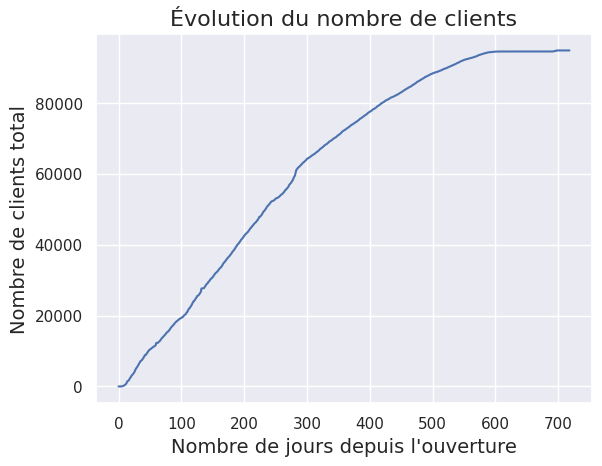

In [3]:
# profile_customers_sorted: Données des clients triées en fonction de la récence
profile_customers_sorted = profile_customers.sort_values('purchase_recency')
# count_clients: Compte le nombre de clients par date de commande la plus récente
count_clients = profile_customers_sorted.groupby(
    'purchase_recency').agg({'state_name': 'count'})
# count_clients: Somme cumulée du nombre de clients par date de commande la plus récente
count_clients = count_clients.cumsum()
plt.plot(count_clients.index, count_clients)
plt.title("Évolution du nombre de clients", fontsize=16)
plt.xlabel("Nombre de jours depuis l'ouverture", fontsize=14)
_ = plt.ylabel("Nombre de clients total", fontsize=14)

On voit que **le nombre de clients augmente linéairement**. On va ignorer la stagnation à la fin de la courbe (x>600), et faire une régression linéaire. Voici les résultats de la régression:

In [4]:
# Au-delà de 600 jours, la courbe n'est plus linéaire
count_clients = count_clients.query('index < 600')
# lin_reg: Régression linéaire
lin_reg = LinearRegression().fit(
    count_clients.index.to_numpy().reshape(-1, 1), count_clients)
# r2: Coefficient de détermination de la régression linéaire
r2 = lin_reg.score(
    count_clients.index.to_numpy().reshape(-1, 1), count_clients)
print("Coefficient de détermination de la régression linéaire: %.2f" % r2)
# clients_per_day: Nombre de nouveaux clients par jour
clients_per_day = lin_reg.coef_[0][0]
print("Le nombre de clients évolue avec une pente de %.2f par jour" %
      clients_per_day)

Coefficient de détermination de la régression linéaire: 0.97
Le nombre de clients évolue avec une pente de 166.47 par jour


Les résultats sont probants, **avec un coefficient de détermination proche de 1**. Cette étude nous permettra d'**évaluer combien de temps la classification restera stable**.

Pour faire cette évaluation, **on se laisse une marge de 60 jours**. On va donc réduire notre échantillon en fonction de cette durée.

In [5]:
# sample_size: Taille de l'échantillon considéré
sample_size = len(profile_customers)-int(round(clients_per_day*60))
print("Les classifications sont réalisées avec un échantillon de %d individus" % sample_size, end='')
print(f" ({round(100*sample_size/len(profile_customers), 2)}% de l'échantillon)")
# inds_sample: Indices des individus sélectionnés
inds_sample = np.random.randint(0, high=len(profile_customers), size=sample_size)

Les classifications sont réalisées avec un échantillon de 84792 individus (89.46% de l'échantillon)


# Baseline: RFM
On commence par faire une classification RFM (Récence, Fréquence, Montant). Comme on l'a vu précédemment, **la fréquence n'est pas une variable pertinente**. On ne l'inclu donc pas dans l'étude.

Il nous reste donc seulement deux variables. Affichons leur graphe pour voir si une classification se dégage naturellement.

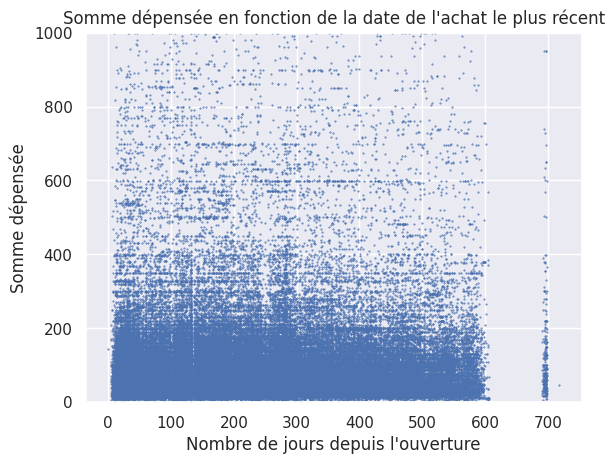

In [6]:
plt.scatter(profile_customers['purchase_recency'], profile_customers['price'], s=.2)
plt.xlabel("Nombre de jours depuis l'ouverture")
plt.ylabel("Somme dépensée")
plt.title('Somme dépensée en fonction de la date de l\'achat le plus récent')
_ = plt.ylim(0, 1000)

**On ne discerne aucune classification**.

En revanche, on voit qu'**aucune commande n'a été réalisée pendant un certain temps entre 600 et 700 jours environ**. On va supprimer les clients correspondants, pour ne pas fausser nos classifications.

In [7]:
# len_data: Enregistre le nombre de clients dont on a le profil
len_data = len(profile_customers)
# Supprime les clients dont la commande la plus récente date de plus de 650 jours
profile_customers = profile_customers.query('purchase_recency < 650').reset_index(drop=True)
# nb_delete: Nombre de clients supprimés de la base de données
nb_delete = len_data-len(profile_customers)
print("On supprime %d individus dont les commandes les plus récentes sont anormalement anciennes" % nb_delete)

On supprime 297 individus dont les commandes les plus récentes sont anormalement anciennes


In [8]:
# std_scaler: Scaler pour centrer et réduie nos données
std_scaler = StandardScaler()
# profiles_scaled: Données centrées-réduites des profils
profiles_scaled = std_scaler.fit_transform(
    profile_customers[columns_quanti].values)
profiles_scaled = pd.DataFrame(profiles_scaled, columns=columns_quanti, index=profile_customers.index)
# sample_size: Taille de l'échantillon considéré
sample_size = len(profile_customers)-int(round(clients_per_day*60))
# inds_sample: Indices des individus sélectionnés
inds_sample = random.sample(range(len(profile_customers)), sample_size)
profiles_train = profiles_scaled.loc[inds_sample]
print("Le set d'entraînement est au format", profiles_train.values.shape)

Le set d'entraînement est au format (84495, 23)


On va utiliser l'algorithme Kmeans.

In [9]:
from sklearn.metrics import silhouette_score

In [26]:
def kmeans_plot(df, n_clusters_list, classification_title):
    inertia_list = []
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init='auto')
        categs = kmeans.fit_predict(df.values)
        inertia_list.append(silhouette_score(df.values, categs, sample_size=5000))
    plt.title("Score de la classification %s avec KMeans" % classification_title, fontsize=16)
    plt.xlabel('Nombre de clusters', fontsize=14)
    plt.ylabel('Indice de silhouette')
    plt.plot(n_clusters_list, inertia_list)

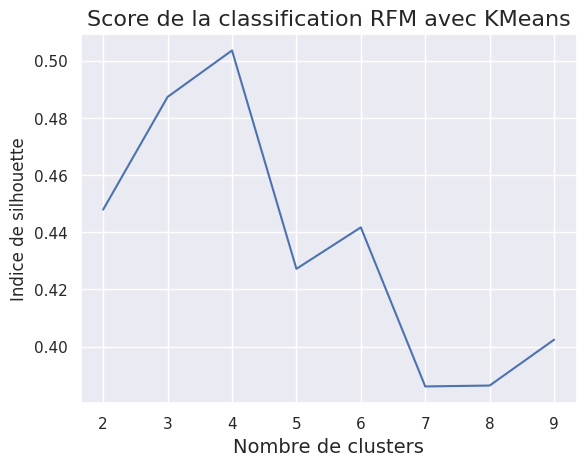

In [27]:
cols_rfm = ['price', 'purchase_recency']
kmeans_plot(profiles_train[cols_rfm], np.arange(2, 10), 'RFM')

On constate que l'indice de silhouette est maximal (à ~0.5) pour 3 clusters. Ce score sera notre baseline, qu'on va essayer de dépasser.

# 2ème itération de la classification

On va ajouter de nouvelles features:
- review_score: La note moyenne des reviews du client
- olist_presece_index: L'indice de spécifité de la clientèle de l'État

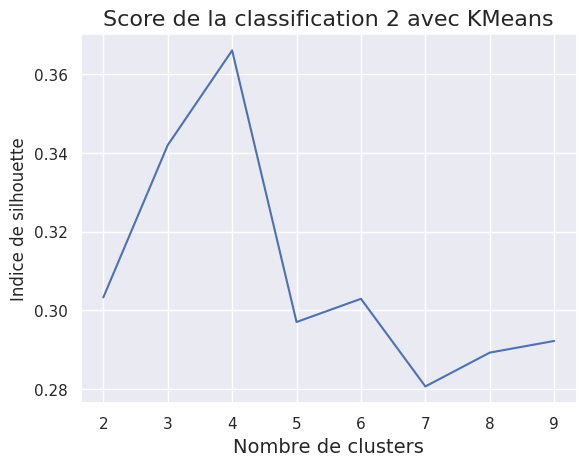

In [25]:
cols_iter2 = cols_rfm + ['review_score']
kmeans_plot(profiles_train[cols_iter2], np.arange(2, 10), '2')

In [28]:
from sklearn.cluster import DBSCAN

In [31]:
db = DBSCAN(eps=0.3, min_samples=10).fit(profiles_train[cols_iter2].values)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette score: %.2f" % silhouette_score(profiles_train[cols_iter2].values, labels))

## Visualisation des données

**On va essayer plusieurs représentations de nos données** pour évaluer si nos données permettent d'effectuer des classifications.

**Certaines méthodes de visualisation sont trop coûteuses en mémoire**. On va représenter seulement une partie de nos données avec ces méthodes.

In [194]:
# viz_size: Taille de l'échantillon réduit pour la visualisation
viz_size = 1000
# inds_viz: Indices des individus à visualiser
inds_viz = np.random.choice(inds_sample, size=viz_size, replace=False)

In [206]:
# k_acp: ACP à noyau utilisée
k_acp = KernelPCA(n_components=2, kernel='rbf')
# tsne: t-SNE utilisée 
tsne = TSNE(n_components=2, init='pca', perplexity=30)
# isomap: Isomap utilisée
isomap = Isomap(n_neighbors=100, n_components=2)

### t-SNE

**Essayons d'ajouter la note moyenne** que donne chaque client. On appellera cette **classification RSM, pour Récence, Score, Montant**.

In [201]:
# columns_rsm: Liste des colonnes Récence, Score, Montant
cols_rsm = cols_rfm + ['review_score']
# rsm_tsne: Profils RSM transformé pour la t-SNE
rsm_tsne = tsne.fit_transform(profiles_train[cols_rsm].loc[inds_viz].values)

Text(0.5, 1.0, 'Profils RSM visualisés par t-SNE')

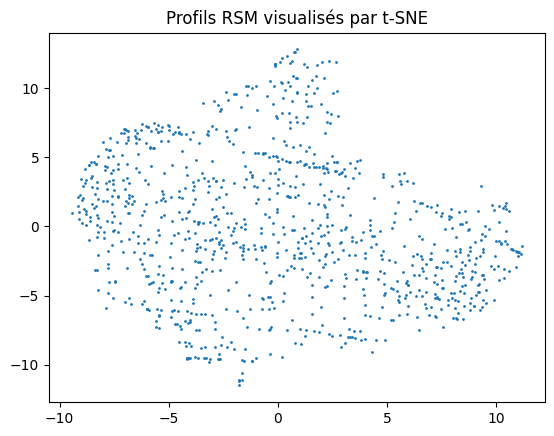

In [202]:
plt.scatter(rsm_tsne[:, 0], rsm_tsne[:, 1], s=1)
plt.title("Profils RSM visualisés par t-SNE")

On voit une classification, mais étant donné qu'on voit 5 classes, ces classes pourraient représenter les notes moyennes données. Essayons de mettre chaque note en couleur pour vérifier cela.

Text(0.5, 1.0, 'Profils RSM visualisés par t-SNE - Couleur=Note')

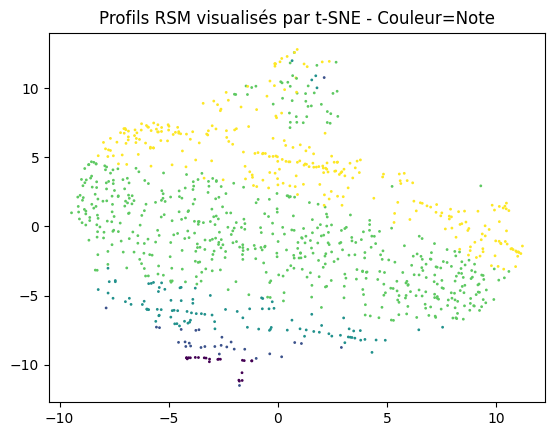

In [203]:
# colors: Valeur de la note moyenne réduite pour chaque individu
colors = profile_customers.loc[inds_viz]['review_score'].round().astype(int)
plt.scatter(rsm_tsne[:, 0], rsm_tsne[:, 1], s=1, c=colors)
plt.title("Profils RSM visualisés par t-SNE - Couleur=Note")

Comme on peut le voir, **chaque cluster représente majoritairement une note**. Il va falloir changer les entrées de nos classifications.

On transforme nos données et on en sélectionne un échantillon, encore une fois, **après avoir ajouté la distance du vendeur préféré**. On appelle cette classification **RSMD pour Récence, Score, Montant, Distance.**

In [25]:
# columns_rsmd: Colonnes utilisées pour la classification RSMD
columns_rsmd = columns_rsm + ['distance_city']
# indices_rsmd: Indices des colonnes de la classification RSMD
inds_rsmd = indices_columns(list(columns_quanti), columns_rsmd)
# rsmd_scaled: Extraction des colonnes de la classification RSMD depuis profiles_scaled
rsmd_scaled = profiles_scaled[:, inds_rsmd]
# rsmd_scaled_sub: Échantillon des profils RSMD utilisé pour l'entraînement
rsmd_scaled_sub = rsmd_scaled[inds_sample]
# rsmd_scaled_viz: Sous-échantillon des profils RSMD à visualiser
rsmd_scaled_viz = rsmd_scaled_sub[inds_viz]

In [194]:
# rsmd_tsne: Profils RSMD transformés par t-SNE
rsmd_tsne = tsne.fit_transform(rsmd_scaled_viz)

Text(0.5, 1.0, 'Profils RSMD visualisés par t-SNE')

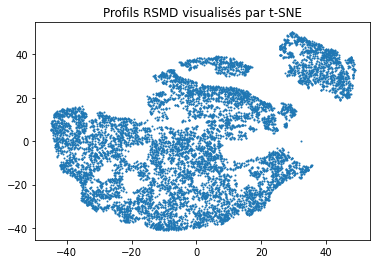

In [195]:
plt.scatter(rsmd_tsne[:, 0], rsmd_tsne[:, 1], s=1)
plt.title("Profils RSMD visualisés par t-SNE")

Voyons si on s'est débarassé du précédent problème.

Text(0.5, 1.0, 'Profils RSMD visualisés par t-SNE - Couleur=Note')

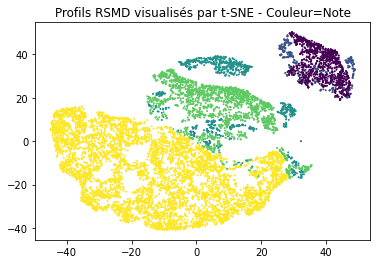

In [196]:
plt.scatter(rsmd_tsne[:, 0], rsmd_tsne[:, 1], s=1, c=colors[inds_viz])
plt.title("Profils RSMD visualisés par t-SNE - Couleur=Note")

On observe que les catégories représentent toujours trop la note.

Ajoutons les variables de la longueur de la description du produit. On appelle cette classification **RSMDT pour Récence, Score, Montant, Distance et Texte.**

In [26]:
# columns_rsmdt: Colonnes utilisées pour la classification RSMDT
columns_rsmdt = columns_rsmd + ['product_description_lenght']
# inds_RSMDT: Indices des colonnes de la classification RSMDT
inds_rsmdt = indices_columns(list(columns_quanti), columns_rsmdt)
# rsmdt_scaled: Extraction des colonnes de la classification RSMDT depuis profiles_scaled
rsmdt_scaled = profiles_scaled[:, inds_rsmdt]
# rsmdt_scaled_sub: Échantillon des profils RSMDT utilisés pour l'entraînement
rsmdt_scaled_sub = rsmdt_scaled[inds_sample]
# rsmdt_scaled_viz: Sous-échantillon des profils RSMDT à visualiser
rsmdt_scaled_viz = rsmdt_scaled_sub[inds_viz]

In [27]:
#rsmdt_tsne: Profils RSMDT transformés par t-SNE
rsmdt_tsne = tsne.fit_transform(rsmdt_scaled_viz)

Text(0.5, 1.0, 'Profils RSMDT visualisés par t-SNE - Couleur=Note')

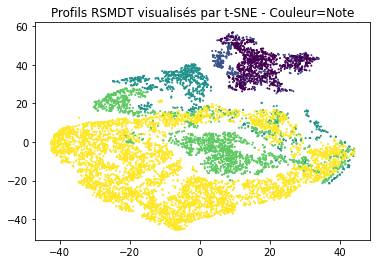

In [28]:
plt.scatter(rsmdt_tsne[:, 0], rsmdt_tsne[:, 1], s=1, c=colors[inds_viz])
plt.title("Profils RSMDT visualisés par t-SNE - Couleur=Note")

On constate que les catégories sont moins homogènes pour la note, ce qui est ce qu'on cherchait.

On déplore ici de ne pas avoir des variables plus pertinentes en entrée. En effet, **les caractéristiques des profils, pour près de 90% d'entre eux, sont calculés à partir d'1 ou 2 achats**. Avec une clientèle plus fidélisée, on aurait pu s'intéresser à la fréquence des achats ou au goûts généraux des clients (avec une NMF). On aurait également pu calculer des distances entre les catégories en observant leurs occurences dans les mêmes commandes.   
Ici, **nos profils sont assez limités**.

On va aussi visualiser nos données avec d'autres méthodes:

### ACP à noyau

In [29]:
# rsmdt_kcpa: Profils RSMDT transformés par ACP à noyau
rsmdt_kcpa = k_acp.fit_transform(rsmdt_scaled_viz)

Text(0.5, 1.0, 'Profils RSMDT visualisés par ACP à noyau gaussien')

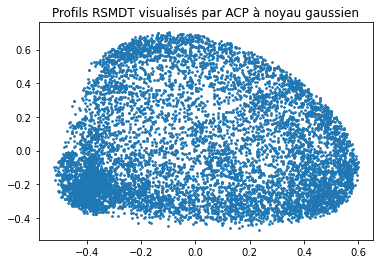

In [30]:
plt.scatter(rsmdt_kcpa[:, 0], rsmdt_kcpa[:, 1], s=3)
plt.title("Profils RSMDT visualisés par ACP à noyau gaussien")

### Isomap

In [31]:
# rsmdt_isomap: Profils RSMDT transformés par Isomap
rsmdt_isomap = isomap.fit_transform(rsmdt_scaled_viz)

Text(0.5, 1.0, 'Profils RSMDT visualisés par Isomap')

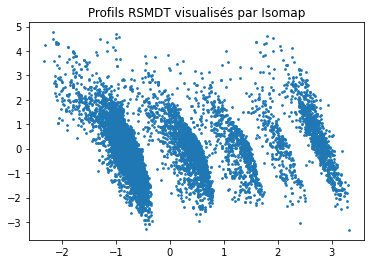

In [32]:
plt.scatter(rsmdt_isomap[:, 0], rsmdt_isomap[:, 1], s=3)
plt.title("Profils RSMDT visualisés par Isomap")

## Classification aléatoire

On va utiliser plusieurs indicateurs pour évaluer nos classifications:
- L'indice de silhouette
- L'indice de Davies-Bouldin
- L'indice de Calinski-Harabasz

Pour l'indice de silhouette, on sait qu'il varie entre -1 et 1, 1 étant la meilleure classification. En revanche, les autres indices ne sont pas bornés: On va regarder les valeurs qu'il prennent pour une classification aléatoire.

In [205]:
def random_classification_scores(data, n_categs, scorings, n_trials=100):
    """Calcule la moyenne de différents types de scores pour plusieurs classifications aléatoires"""
    # n_individuals: Nombre d'individus à classer
    n_individuals = len(data)
    # scores_lists: Contient une liste pour chaque type de score
    scores_lists = [[] for score_type_index in range(len(scorings))]
    # On va calculer les scores pour plusieurs classifications aléatoires
    for ind_trial in range(n_trials):
        # categs: Catégories pour chaque individu
        categs = np.random.randint(0, n_categs, size=n_individuals)
        # On ajoute chaque score dans sa liste attribuée
        for ind_scoring, scoring in enumerate(scorings):
            scores_lists[ind_scoring].append(scoring(data, categs))
    return [np.mean(scores) for scores in scores_lists]
# scorings: Types de scores à tester avec des classifications aléatoire
scorings = [davies_bouldin_score, calinski_harabasz_score]
# scores: Scores moyens optenus avec des classifications aléatoires
scores = random_classification_scores(rsmdt_scaled_sub, n_clusters, scorings, n_trials=100)
print("Scores pour classifications aléatoires:")
print("Score de Davies-Bouldin: %2f" % scores[0])
print("Score de Calinski-Harabasz: %2f" % scores[1])

Scores pour classifications aléatoires:
Score de Davies-Bouldin: 252.790305
Score de Calinski-Harabasz: 0.974875


## Classifications avec les données d'origine 
On va utiliser plusieurs classifieurs:
- K-mean
- DBSCAN
- Classifieur agglomératif

Pour chacun d'entre eux, on va calculer plusieurs scores, et on va visualiser la classification.

In [38]:
def plot_categs(categs, maps_list, maps_labels, point_size=3):
    """Affiche les catégories en couleur sur des graphes"""
    for a_map, map_label in zip(maps_list, maps_labels):
        plt.subplots()
        plt.title(map_label)
        plt.scatter(a_map[:, 0], a_map[:, 1], c=categs, s=point_size)


# maps_list: Liste des ensembles de coordonnées pour chaque représentation des données
maps_list = [rsmdt_kcpa, rsmdt_tsne, rsmdt_isomap]
# maps_labels: Nom de chaque représentation
maps_labels = ['K-CPA', 't-SNE', 'Isomap']

### KMeans 

#### Choix du nombre de clusters

In [207]:
def scores_for_params(classifier_constructor, data, param_name, param_values, scoring=davies_bouldin_score, kwargs=None):
    """Calcule les scores pour un classifieur en fonction d'un paramètre"""
    # scores: Listes des scores
    scores = []
    # kwargs: Arguments nommés supplémentaires du classifieur
    kwargs = {} if kwargs is None else kwargs
    # param_value: Valeur du paramètre variable
    for param_value in param_values:
        kwargs[param_name] = param_value  # Ajoute le paramètre variable
        # classifier: Classifieur construit
        classifier = classifier_constructor(**kwargs)
        # categs: Liste des catégories de chaque client
        categs = classifier.fit_predict(data)
        scores.append(scoring(data, categs))
    return scores

Text(0, 0.5, 'Davies-Bouldin score')

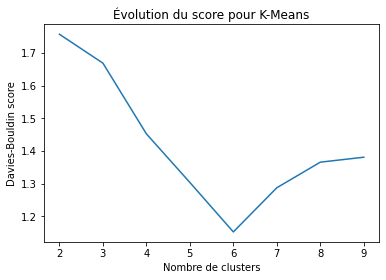

In [208]:
# list_n_clusters: Liste des nombres de clusters à tester
list_n_clusters = np.arange(2, 10)
# scores_kmeans: Scores les obtenus pour chaque valeur du nombre de clusters 
scores_kmeans = scores_for_params(
    KMeans, rsmdt_scaled_sub, 'n_clusters', list_n_clusters)
plt.plot(list_n_clusters, scores_kmeans)
plt.title("Évolution du score pour K-Means")
plt.xlabel("Nombre de clusters")
plt.ylabel("Davies-Bouldin score")

Text(0, 0.5, 'Indice de Calinski-Harabasz')

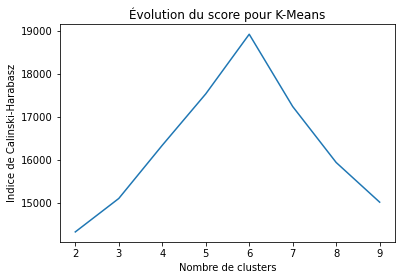

In [209]:
# list_n_clusters: Liste des nombres de clusters à tester
list_n_clusters = np.arange(2, 10)
# scores_kmeans: Scores les obtenus pour chaque valeur du nombre de clusters 
scores_kmeans = scores_for_params(
    KMeans, rsmdt_scaled_sub, 'n_clusters', list_n_clusters, scoring=calinski_harabasz_score)
plt.plot(list_n_clusters, scores_kmeans)
plt.title("Évolution du score pour K-Means")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de Calinski-Harabasz")

Avec l'indice de **silhouette**:

Text(0, 0.5, 'Indice de silhouette')

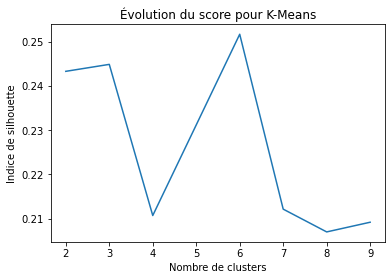

In [210]:
# list_n_clusters: Liste des nombres de clusters à tester
list_n_clusters = np.arange(2, 10)
# scores_kmeans: Scores les obtenus pour chaque valeur du nombre de clusters 
scores_kmeans = scores_for_params(
    KMeans, rsmdt_scaled_sub, 'n_clusters', list_n_clusters, scoring=silhouette_score)
plt.plot(list_n_clusters, scores_kmeans)
plt.title("Évolution du score pour K-Means")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")

On fait le choix de prendre le nombre de clusters qui optimise l'ensemble des critères: 6.

**Performances**

In [33]:
# n_clusters: Nombre de clusters optimal pour k-Means
n_clusters=6
# kmeans: Classifieur K-Means optimal des profils RSMDT 
kmeans = KMeans(n_clusters=n_clusters).fit(rsmdt_scaled_sub)
# categs_kmeans: Catégories de chaque profils donnés par le classifieur K-Means
categs_kmeans = kmeans.predict(rsmdt_scaled_sub)

In [34]:
print("Pour K-Means:")
print("Score de sihouette: %.2f" %
      silhouette_score(rsmdt_scaled_sub, categs_kmeans))
print("Score de Davis-Bouldin: %.2f" %
      davies_bouldin_score(rsmdt_scaled_sub, categs_kmeans))
print("Score de calinski-harabasz: %.2f" %
      calinski_harabasz_score(rsmdt_scaled_sub, categs_kmeans))

Pour K-Means:
Score de sihouette: 0.25
Score de Davis-Bouldin: 1.15
Score de calinski-harabasz: 19000.34


**Les résultats obtenus ici sont satisfaisants**, particulièrement pour les deux derniers scores. Par rapport à une classification aléatoire, on a un score de Davies-Bouldin plus de 200x inférieur, et un score de Calinski-Harabasz ~19000x supérieur.

**Profils moyens**

Essayons d'interpréter les résultats en s'intéressant aux individus moyens par catégorie:

In [35]:
# data_rsmdt: Données d'origine des profils RSMDT
data_rsmdt = profile_customers[columns_rsmdt].iloc[inds_sample].copy()

In [36]:
data_rsmdt["class_kmeans"] = categs_kmeans  # Ajoute les classifications obtenus avec K-Means
# mean_profiles_kmeans: Profils moyens par catégorie
mean_profiles_kmeans = data_rsmdt.groupby('class_kmeans').mean()
mean_profiles_kmeans['proportion'] = 100*data_rsmdt.groupby('class_kmeans').count()['recency']/len(data_rsmdt)
mean_profiles_kmeans

,recency,total_spent,review_score,distance_city,product_description_lenght,proportion
class_kmeans,,,,,,
0,236.240497,292.971289,4.312281,0.041387,798.814192,9.284774
1,211.421035,122.188750,4.387108,0.044701,2377.550523,8.002009
2,240.290382,96.232142,1.397080,0.045860,647.776722,13.294602
3,222.271703,84.505312,4.408584,0.152431,661.506635,12.524943
4,118.033824,76.356245,4.640858,0.032479,615.173934,32.346034
5,395.940002,76.756506,4.608051,0.032751,586.037736,24.547639


On constate que chaque catégorie a des caractéristiques particulières. Certaines ont de haut prix, d'autres des produits décrits longuement, certains donnent des notes basses...

**La classification est donc interprétable**.

Essayons de visualiser ces catégories par des couleurs.

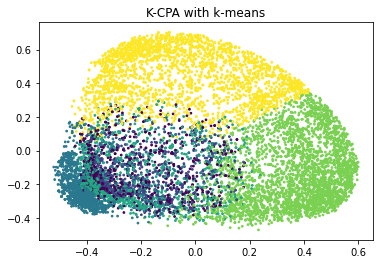

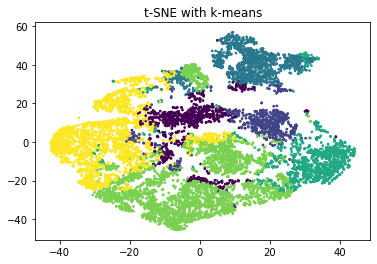

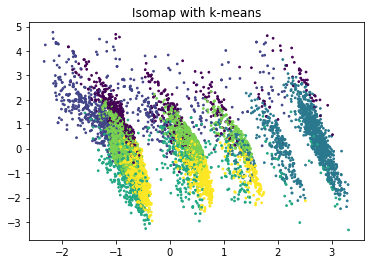

In [39]:
# maps_labels_kmeans: Titres des visualisations pour K-Means
maps_labels_kmeans = [label+' with k-means' for label in maps_labels]
plot_categs(categs_kmeans[inds_viz], maps_list, maps_labels_kmeans)

### DBSCAN

**Paramétrage**

In [217]:
def grid_search_dbscan(data, eps_values, min_samples_values, n_clusters_boundaries, scoring, search_min=True):
    """Effectue une recherche par grille des meilleurs paramètres pour DBSCAN"""
    # score_opt: Score optimal
    score_opt = inf if search_min else -inf
    # optimum: Fonction déterminant le type d'extremum
    optimum = min if search_min else max
    # eps_opt, min_samples_opt: Paramètres optimaux
    eps_opt, min_samples_opt = None, None
    # On va simplement boucler sur les valeurs des paramètres à tester
    for min_samples in min_samples_values:
        for eps in eps_values:
            # categs: Labels des individus calculés par DBSCAN
            categs = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(data)
            # score: Score obtenu
            score = scoring(data, categs)
            # n_clusters: Nombre de clusters repérés
            n_clusters = len(np.unique(categs))-1
            if optimum(score, score_opt) != score_opt:  # Si le nouveau score est plus optimal
                # On borne le nombre de clusters, par souci d'interprétabilité
                if n_clusters >= n_clusters_boundaries[0] and n_clusters <= n_clusters_boundaries[1]:
                    eps_opt, min_samples_opt, score_opt = eps, min_samples, score
                # Dans le cas où on n'a pas encore trouvé un nombre de catégories satisfaisant
                elif not isfinite(score):
                    eps_opt, min_samples_opt, score_opt = eps, min_samples, score
    return eps_opt, min_samples_opt, score_opt

On effectue notre recherche par grille:

In [218]:
eps_values=np.linspace(0.75, 1, 5*4+1)
min_samples_values = [5, 10, 15]
result = grid_search_dbscan(rsmdt_scaled_sub, eps_values, min_samples_values, [2, 9], davies_bouldin_score)
eps, min_samples, score = result

Les paramètres optimaux pour DBSCAN sont les suivants:

In [219]:
print("eps = %.2f" % eps)
print("min_samples = %d" % min_samples)
print("Avec ces paramètres, on a un score de Davies-Bouldin valant %.2f" % score)

eps = 0.96
min_samples = 5
Avec ces paramètres, on a un score de Davies-Bouldin valant 1.05


**Performances**

In [220]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
categs_dbscan = dbscan.fit_predict(rsmdt_scaled_sub)

In [221]:
print("Avec DBSCAN, on repère %d catégories" % len(set(categs_dbscan)))

Avec DBSCAN, on repère 5 catégories


In [222]:
print("Score de sihouette pour DBSCAN: %.2f" %
      silhouette_score(rsmdt_scaled_sub, categs_dbscan))
print("Score de Davis-Bouldin pour DBSCAN: %.2f" %
      davies_bouldin_score(rsmdt_scaled_sub, categs_dbscan))
print("Score de calinski-harabasz pour DBSCAN: %.2f" %
      calinski_harabasz_score(rsmdt_scaled_sub, categs_dbscan))

Score de sihouette pour DBSCAN: 0.42
Score de Davis-Bouldin pour DBSCAN: 1.05
Score de calinski-harabasz pour DBSCAN: 176.53


On constate que pour un indice de Davies-Bouldin légèrement meilleur que celui de K-Means, on a des scores de silhouette et de Calinski-Harabasz plus mauvais.

**Profils moyens**

Voyons si les résultats sont interprétables:

In [223]:
data_rsmdt["class_dbscan"] = categs_dbscan
mean_profiles_dbscan = data_rsmdt.groupby('class_dbscan').mean()
mean_profiles_dbscan['proportion'] = 100*data_rsmdt.groupby('class_dbscan').count()['recency']/len(data_rsmdt)
mean_profiles_dbscan

,recency,total_spent,review_score,distance_city,product_description_lenght,class_kmeans,proportion
class_dbscan,,,,,,,
-1,267.174699,268.901145,2.855422,0.149169,2627.243976,2.632530,0.225332
0,233.296835,103.255957,4.120819,0.050755,766.919749,2.038799,99.746162
1,455.666667,49.631667,1.000000,0.027294,3827.166667,4.000000,0.008145
2,381.888889,331.400000,5.000000,0.014555,3852.333333,2.000000,0.012217
3,563.500000,391.333333,1.000000,0.043052,2362.833333,2.000000,0.008145


On constate qu'on a des catégories extrêmement disproportionnées.

**Alternative - Score de Calinski-Harabasz**

Essayons d'optimiser un autre score.

In [224]:
eps_values=np.linspace(0.75, 1, 5*4+1)
min_samples_values = [5, 10, 15]
result = grid_search_dbscan(rsmdt_scaled_sub, eps_values, min_samples_values, [2, 9], calinski_harabasz_score, search_min=False)
eps, min_samples, score = result

In [225]:
print("eps = %.2f" % eps)
print("min_samples = %d" % min_samples)
print("Avec ces paramètres, on a un score de Davies-Bouldin valant %.2f" % score)

eps = 0.75
min_samples = 15
Avec ces paramètres, on a un score de Davies-Bouldin valant 3776.04


In [226]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
categs_dbscan = dbscan.fit_predict(rsmdt_scaled_sub)

In [227]:
print("Avec DBSCAN, on repère %d catégories" % len(set(categs_dbscan)))

Avec DBSCAN, on repère 7 catégories


In [228]:
print("Score de sihouette pour DBSCAN: %.2f" %
      silhouette_score(rsmdt_scaled_sub, categs_dbscan))
print("Score de Davis-Bouldin pour DBSCAN: %.2f" %
      davies_bouldin_score(rsmdt_scaled_sub, categs_dbscan))
print("Score de calinski-harabasz pour DBSCAN: %.2f" %
      calinski_harabasz_score(rsmdt_scaled_sub, categs_dbscan))

Score de sihouette pour DBSCAN: 0.02
Score de Davis-Bouldin pour DBSCAN: 3.64
Score de calinski-harabasz pour DBSCAN: 3776.04


Voyons si les résultats sont interprétables:

In [229]:
data_rsmdt["class_dbscan"] = categs_dbscan
mean_profiles_dbscan = data_rsmdt.groupby('class_dbscan').mean()
mean_profiles_dbscan['proportion'] = 100*data_rsmdt.groupby('class_dbscan').count()['recency']/len(data_rsmdt)
mean_profiles_dbscan

,recency,total_spent,review_score,distance_city,product_description_lenght,class_kmeans,proportion
class_dbscan,,,,,,,
-1,282.533630,223.055618,2.992087,0.121264,1855.113996,2.636004,2.744709
0,236.788171,99.483295,4.000000,0.047557,738.184693,1.736658,19.025642
1,229.202078,100.459452,5.000000,0.049517,764.196092,1.696319,57.742062
2,235.816667,89.816594,2.000000,0.045465,627.630295,3.870312,2.606252
3,233.454582,107.782990,1.000000,0.050790,691.186693,3.893890,10.042216
4,238.607639,94.920227,3.000000,0.047146,678.465828,2.114410,7.818757
5,191.466667,162.186667,1.000000,0.145726,2100.500000,4.000000,0.020361


L'algorithme fait une classification selon la note, ce qui n'est pas intéressant.

**Alternative - Score de silhouette**   
Le temps d'exécution est beaucoup trop important.

In [231]:
eps_values=np.linspace(0.75, 1, 5*4+1)
min_samples_values = [5, 10, 15]
result = grid_search_dbscan(rsmdt_scaled_sub, eps_values, min_samples_values, [2, 9], silhouette_score, search_min=False)
eps, min_samples, score = result

In [232]:
print("eps = %.2f" % eps)
print("min_samples = %d" % min_samples)
print("Avec ces paramètres, on a un score de silhouette valant %.2f" % score)

eps = 1.00
min_samples = 5
Avec ces paramètres, on a un score de silhouette valant 0.44


In [233]:
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
categs_dbscan = dbscan.fit_predict(rsmdt_scaled_sub)

In [234]:
print("Avec DBSCAN, on repère %d catégories" % len(set(categs_dbscan)))

Avec DBSCAN, on repère 4 catégories


In [235]:
print("Score de sihouette pour DBSCAN: %.2f" %
      silhouette_score(rsmdt_scaled_sub, categs_dbscan))
print("Score de Davis-Bouldin pour DBSCAN: %.2f" %
      davies_bouldin_score(rsmdt_scaled_sub, categs_dbscan))
print("Score de calinski-harabasz pour DBSCAN: %.2f" %
      calinski_harabasz_score(rsmdt_scaled_sub, categs_dbscan))

Score de sihouette pour DBSCAN: 0.44
Score de Davis-Bouldin pour DBSCAN: 1.05
Score de calinski-harabasz pour DBSCAN: 176.65


Voyons si les résultats sont interprétables:

In [236]:
data_rsmdt["class_dbscan"] = categs_dbscan
mean_profiles_dbscan = data_rsmdt.groupby('class_dbscan').mean()
mean_profiles_dbscan['proportion'] = 100*data_rsmdt.groupby('class_dbscan').count()['recency']/len(data_rsmdt)
mean_profiles_dbscan

,recency,total_spent,review_score,distance_city,product_description_lenght,class_kmeans,proportion
class_dbscan,,,,,,,
-1,269.253968,272.249048,2.722222,0.152078,2683.202381,2.674603,0.171035
0,233.334480,103.372260,4.120424,0.050799,768.230525,2.039044,99.814033
1,455.666667,49.631667,1.000000,0.027294,3827.166667,4.000000,0.008145
2,562.000000,390.000000,1.000000,0.037501,2431.400000,2.000000,0.006787


On constate ici aussi que les clusters sont très disproportionnés.

## Clustering hiérarchique

Ici, l'algorithme est très gourmand en mémoire. **On est obligé de sélectionner un sous-échantillon assez faible** de nos données. (ici, 1/4 des données d'entraînement)

In [237]:
# indices_agg: Indice du sous-échantillon
indices_agg = np.random.randint(0, high=len(rsmdt_scaled_sub), size=int(len(rsmdt_scaled_sub)/4))

Text(0, 0.5, 'Davies-Bouldin score')

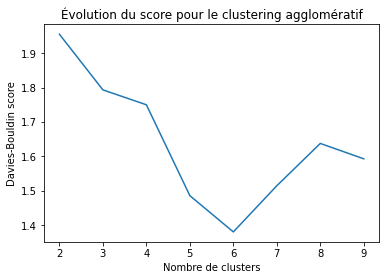

In [238]:
list_n_clusters = np.arange(2, 10)
scores_agg = scores_for_params(
    AgglomerativeClustering, rsmdt_scaled_sub[indices_agg], 'n_clusters', list_n_clusters)
plt.plot(list_n_clusters, scores_agg)
plt.title("Évolution du score pour le clustering agglomératif")
plt.xlabel("Nombre de clusters")
plt.ylabel("Davies-Bouldin score")

In [239]:
agglomerative = AgglomerativeClustering(n_clusters=6, linkage='ward')
categs_agg = agglomerative.fit_predict(rsmdt_scaled_sub[indices_agg])

In [240]:
print("Score de sihouette pour la classification agglomérative: %.2f" %
      silhouette_score(rsmdt_scaled_sub[indices_agg], categs_agg))
print("Score de Davis-Bouldin pour la classification agglomérative: %.2f" %
      davies_bouldin_score(rsmdt_scaled_sub[indices_agg], categs_agg))
print("Score de calinski-harabasz pour la classification agglomérative: %.2f" %
      calinski_harabasz_score(rsmdt_scaled_sub[indices_agg], categs_agg))

Score de sihouette pour la classification agglomérative: 0.14
Score de Davis-Bouldin pour la classification agglomérative: 1.38
Score de calinski-harabasz pour la classification agglomérative: 3155.99


Interprétation des catégories:

In [241]:
data_rsmdt_sub = data_rsmdt.iloc[indices_agg]
data_rsmdt_sub["class_agg"] = categs_agg
mean_profiles_agg = data_rsmdt_sub.groupby('class_agg').mean()
mean_profiles_agg['proportion'] = 100*data_rsmdt_sub.groupby('class_agg').count()['recency']/len(indices_agg)
mean_profiles_agg

/home/ilyes/anaconda3/envs/env_p5/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,recency,total_spent,review_score,distance_city,product_description_lenght,class_kmeans,class_dbscan,proportion
class_agg,,,,,,,,
0,250.388411,89.688646,4.483936,0.128095,727.098814,2.405622,-0.002008,18.928164
1,198.839741,107.838830,4.607042,0.031004,1699.381897,2.254148,-0.000809,13.416952
2,233.631889,77.966019,2.026316,0.043736,660.970820,2.861610,-0.000929,17.538144
3,334.866301,64.392100,4.745710,0.024372,512.394066,0.815777,0.000000,22.783298
4,256.918455,292.796640,3.786021,0.033027,879.867545,2.475782,-0.006131,8.855948
5,97.313547,95.600937,4.807229,0.033713,471.865731,1.913312,0.000000,18.477494


On voit des particularités pour chaque classification, ce qui rend ces catégories interprétable.

# Stabilité de la classification

L'algorithme retenu est le K-Means. En effet, on obtient avec cet algorithme des catégories interprétables et les meilleures performances.

## Stabilité sur plusieurs itérations

Voyons si on obtient la même classification sur plusieurs itérations.

On commence par créer quelques fonctions utiles

In [40]:
def indices(list_values, value_to_find):
    """Retourne les indices d'apparition d'une valeur dans une liste"""
    indices_list = []
    for ind, value in enumerate(list_values):
        if value == value_to_find:
            indices_list.append(ind)
    return indices_list

In [41]:
def intersection_and_rest(cluster_labels_1, cluster_labels_2):
    """Retourne l'intersection entre deux ensembles et le reste des éléments de la 1ère liste restants"""
    intersection, rest = [], []
    for label in cluster_labels_1:
        if label in cluster_labels_2:
            intersection.append(label)
        else:
            rest.append(label)
    return intersection, rest

In [42]:
def stability_segmentation(clusters_1, clusters_2, clusters_labels, n_individuals):
    """Retourne le pourcentage d'individus classés de la même manière dans deux classifications"""
    # mat_scores: Contient la taille de l'intersection entre chaque couple de clusters de chaque classification
    mat_scores = np.zeros((len(clusters_labels), len(clusters_labels)))
    # clusters_1_copy: Copie des clusters de la première classification
    custers_1_copy = deepcopy(clusters_1)
    # ind_1: Indice du cluster dans la 1ère classification
    for ind_1 in clusters_labels:
        # ind_2: Indice du cluster dans la 2ème classification
        for ind_2 in clusters_labels:
            # intersection: Intersection entre 2 clusters de chaque classification
            # rest: Individus du cluster la 1ère classification hors de l'intersection
            intersection, rest = intersection_and_rest(
                custers_1_copy[ind_1], clusters_2[ind_2])
            # Enregistre la taille de l'intersection
            mat_scores[ind_1][ind_2] = len(intersection)
            # Garde les individus qui n'ont pas été repérés dans la classification 2
            custers_1_copy[ind_1] = rest
    # score_max: Somme des tailles d'intersection la plus élevée possible
    score_max = -inf
    # order_clusters: Liste des indices des clusters de la classification 2
    # On cherche la meilleur correspondance entre chaque cluster de la classification 1 à un 
    # cluster de la classification 2
    for order_clusters in permutations(clusters_labels):
        # score: Score obtenu pour cette répartition des clusters
        score = sum([mat_scores[c1][c2]
                    for c1, c2 in zip(clusters_labels, order_clusters)])
        # On retient ce score s'il est meilleur
        score_max = max(score, score_max)
    return score_max/n_individuals

In [43]:
def from_labels_to_clusters(individuals_labels, possible_labels):
    clusters = []
    for label in possible_labels:
        clusters.append(indices(individuals_labels, label))
    return clusters

On va maintenant calculer la stabilité moyenne en fonction du nombre de clusters choisi. Étant donné un nombre de clusters, on va calculer plusieurs classifications, et calculer la correspondance moyenne entre chaque couple de ces classifications.

In [44]:
# n_segmentations: Nombre de segmentations par nombre de clusters, dont on va tester la correspondance
n_segmentations = 5
n_clusters = 6
# scores: Liste des scores obtenu
scores = []
# clusters_labels: Label de chaque cluster
clusters_labels = [i for i in range(n_clusters)]
# clusters_list: Liste des classifications: Contient pour chacune le contenu de ses clusters
clusters_list = []
for i in range(n_segmentations):
    kmeans = KMeans(n_clusters=n_clusters).fit(rsmdt_scaled_sub)
    # categs_new: Labels de la nouvelles classification pour chaque individu
    categs_new = kmeans.predict(rsmdt_scaled_sub)
    # clusters_new: Listes des indices des individus par cluster
    clusters_new = from_labels_to_clusters(list(categs_new), clusters_labels)
    # On enregistre la classification
    clusters_list.append(clusters_new)
# On calcule la correspondance entre chaque couple de classification
for clusters_1, clusters_2 in combinations(clusters_list, 2):
    # Ajoute un score à la liste
    scores.append(stability_segmentation(clusters_1, clusters_2, clusters_labels, len(categs_new)))
# mean_score: Contient le score moyen de correspondance
mean_score = np.mean(scores)

In [45]:
print("Avec 6 clusters, on a une stabilité moyenne de %.2f%s" % (100*mean_score, '%'))

Avec 6 clusters, on a une stabilité moyenne de 99.89%


## Stabilité sur ajout de données

Vérifions maintenant si les catégories sont influencées par l'ajout de données. Ce sera le cas de toute façon, mais si elle sont trop influencées, cela signifiera que nos catégories sont spécifiques à nos données et pas ç une dynamique réelle dans la clientèle. À partir d'une variation de 10%, on commence à considérer qu'il faut recommencer la classification.

In [46]:
categs_origin = list(data_rsmdt['class_kmeans'])

In [47]:
n_segmentations = 5
scores = []
# n_clusters: Nombre de clusters optimal pour k-Means
n_clusters=6
clusters_labels = [i for i in range(n_clusters)]
clusters_origin = from_labels_to_clusters(categs_origin, clusters_labels)
for i in range(n_segmentations):
    # kmeans: Classifieur K-Means optimal des profils RSMDT
    kmeans = KMeans(n_clusters=n_clusters).fit(rsmdt_scaled)
    # categs_kmeans: Catégories de chaque profils donnés par le classifieur K-Means
    categs_new = kmeans.predict(rsmdt_scaled)
    clusters_new = from_labels_to_clusters(list(categs_new[inds_sample]), clusters_labels)
    scores.append(stability_segmentation(clusters_origin, clusters_new, clusters_labels, len(categs_origin)))
mean_score = np.mean(scores)

In [48]:
print("La segmentation a une stabilité de %.2f%s avec les données complètes" % (100*mean_score, '%'))

La segmentation a une stabilité de 99.25% avec les données complètes
